**In this notebook, we want to add 10 features that highlight the important qualities of these buildings:** (that can be later used for correlation analysis.)
- building_type: pre-war, post-war
- building_category: walkup, elevator, single family, 2 family, condo-co-op, or other residential
- is_condo: a particular column focused on condo
- floor_category: high-rise, mid-rise, or low-rise
- rent_era: the rent regulazation act eras the buildings were built
- architectural_style: the architectural style the era the buildings were built
- economic_period: the economic development period that the buildings were built
- building_age category: categorize the buildings by decades
- residential_units_category: buildings with small, mid, large amount of units
- is_llc: whether a building is llc owned.
- building_size_category: categorize the buildings based on the areas they have (based on the conventional definition of what is a large, mid-sized, or small building) \
  size_quartile: categorize the buildings based on the areas they have (based on the quartile they are in)

**We save this cleaned and enhanced bbl_df to drive and will merge it with the eviction dataset later to conduct correlation analysis.**

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
file_path1 = '/content/drive/My Drive/X999/BBL.csv'

In [8]:
bbl = pd.read_csv(file_path1)

In [9]:
bbl_df = bbl.copy()

In [10]:
bbl_df.columns, bbl_df.shape
# original bbl_df shape: (858189, 99)

(Index(['borough', 'block', 'lot', 'community board', 'census tract 2010',
        'cb2010', 'schooldist', 'council district', 'postcode', 'firecomp',
        'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address',
        'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
        'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
        'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
        'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
        'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
        'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
        'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
        'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
        'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
        'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
        'condono', 'tract2010'

In [11]:
bbl_df.head(4)

,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,version,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes
0,BX,2587,22,201.0,19.00,3026.0,7.0,17.0,10454.0,L029,40.0,4700.0,2.0,2A,EAST 136 STREET,M1-2,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,U6,7.0,0.0,X,NATIONAL RAILROAD PASSENGER CORP,31525.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,0.0,134.5,202.67,0.0,0.0,N,0.0,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.00,2.0,4.8,2,2025870022,NaN,19.0,1008873.0,231471.0,40.801976,-73.911062,6d,NaN,209S022,21002.0,NaN,NaN,NaN,1,20v5,1.0,23.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MN,135,14,101.0,21.00,1002.0,2.0,1.0,10007.0,L010,1.0,7700.0,1.0,1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1001350014,NaN,21.0,982036.0,199596.0,40.714522,-74.007988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,20v5,1.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BK,7087,5,311.0,410.00,1000.0,21.0,47.0,11223.0,E253,62.0,8510.0,3.0,6C,LAKE STREET,M1-1,R5B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,U1,7.0,0.0,X,BKLYN UNION GAS CO,7949.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,N,0.0,False,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.00,1.0,2.4,3,3070870005,NaN,410.0,991764.0,158435.0,40.601540,-73.972941,28c,NaN,314 053,32105.0,NaN,NaN,NaN,1,20v5,11.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,QN,2930,10,405.0,665.01,4004.0,24.0,30.0,11379.0,L136,104.0,1822.0,4.0,1C,ELIOT AVENUE,R4,NaN,NaN,NaN,C2-2,NaN,NaN,NaN,NaN,NaN,False,U6,7.0,0.0,X,NEW YORK CENTRAL LINES,42328.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,0.0,151.0,130.00,0.0,0.0,N,0.0,True,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.75,0.0,2.0,4,4029300010,NaN,66501.0,1016142.0,202274.0,40.721815,-73.884945,13c,NaN,420 015,41601.0,NaN,NaN,NaN,1,20v5,5.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Step 1**: we need to only select the residential buildings

#### PLUTO, building classes definitions:
https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page#:~:text=PLUTO%3A%20Extensive%20land%20use%20and,data%20maintained%20by%20city%20agencies.

### R + are residential buildings, R+ number meaning the number of rooms that building has. R + letter meaning the type of the building it is.
### A + are apartments
### M + are mixed use buildings. (commercial + residential/commercial + industry)
### C+ walk up, could be condo or co-op
### D+ elevator, could be condo or co-op
### C and D could cover certain condo and co-op buildings, and therefore, later the percentage of condo/co-op would be much lower than we expected.
We mainly focus on R+ and A+ buildings at this point, because mixed used could be a combination of different building uses, and they only represent around 0.658% of all buildings in NYC.

In [12]:
bbl_df['bldgclass'].unique()

array(['U6', nan, 'U1', 'G0', 'U2', 'U7', 'A5', 'U9', 'R3', 'U0', 'RM',
       'Z9', 'Z7', 'U4', 'R2', 'S4', 'RX', 'C1', 'C3', 'B3', 'A1', 'B2',
       'C2', 'C0', 'R4', 'B1', 'M1', 'V0', 'K4', 'W1', 'S5', 'R1', 'O2',
       'D1', 'A9', 'O4', 'M9', 'D8', 'D7', 'C7', 'R6', 'A2', 'K1', 'D4',
       'A3', 'A4', 'O6', 'S2', 'S9', 'C6', 'F1', 'G8', 'F5', 'F9', 'U5',
       'E2', 'S1', 'G6', 'C4', 'E9', 'V1', 'B9', 'G7', 'K2', 'C5', 'O5',
       'K9', 'P7', 'S3', 'O3', 'D2', 'D5', 'RC', 'D0', 'D9', 'RB', 'P5',
       'M2', 'N2', 'M3', 'H3', 'J9', 'RD', 'C9', 'K7', 'W6', 'D3', 'P6',
       'W8', 'M4', 'E1', 'K5', 'D6', 'F4', 'G4', 'A7', 'G1', 'G2', 'O1',
       'S0', 'O8', 'RK', 'W7', 'H2', 'RI', 'P9', 'Z4', 'J4', 'W4', 'W2',
       'H6', 'W3', 'HR', 'Z0', 'W9', 'RH', 'H5', 'H8', 'I7', 'P3', 'O7',
       'I5', 'P8', 'Z8', 'I9', 'F2', 'V2', 'GW', 'I1', 'T9', 'P2', 'C8',
       'Q1', 'O9', 'A0', 'Q0', 'RR', 'Q2', 'P1', 'Z1', 'Y7', 'V5', 'W5',
       'V9', 'Q6', 'V3', 'Q9', 'Q3', 'G9', 'T2', 'Q8

PLUTO building code definition source:
https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html

In [13]:
residential_codes = [
    # single-family
    'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
    # Two-family homes
    'B1', 'B2', 'B3', 'B9',
    # walk-up apartments
    'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'CB', 'CC',
    # elevator apartments
    'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DB', 'DC',
    # condo/Co-op res
    'R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'RR',
    # APARTMENT HOTEL - COOPERATIVELY OWNED
    'H7',
    # Mixed-use residential
    'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S9'
]

In [14]:
bbl_df = bbl_df[bbl_df['bldgclass'].isin(residential_codes)]
bbl_df.shape, bbl.shape, 753122/858189
# about 87.76% of buildings in nyc are residential buildings
# no official data to confirm this percentage on the web, but sounds reasonable to me, personally.
# did not include the mixed use building if they were not primarily residential

((753122, 99), (858189, 99), 0.8775712576134161)

# **Added Feature 1**: categorize **Building Category (based on usage)**

In [15]:
def categorize_building_type(bldg_class):
    condo_coop_codes = [
        # condo codes
        'R1', 'R2', 'R3', 'R4', 'R6', 'R9',
        # co-op codes embedded in walk-up/elevator categories
        'C6', 'C8', 'CC', 'D0', 'D4', 'DC',
        # additional relevant condo/co-op codes
        'R0', 'R5', 'R7', 'R8', 'RR', 'H7'
    ]

    if bldg_class in condo_coop_codes:
        return "condo-co-op"
    elif bldg_class in ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']:
        return "single-family"
    elif bldg_class in ['B1', 'B2', 'B3', 'B9']:
        return "two-family"
    elif bldg_class in ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C9', 'CB']:
        return "walk-up"
    elif bldg_class in ['D1', 'D2', 'D3', 'D5', 'D6', 'D7', 'D8', 'D9', 'DB']:
        return "elevator"
    elif bldg_class in ['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S9']:
        return "primarily_res_with_mixed_use"

bbl_df['building_category'] = bbl_df['bldgclass'].apply(categorize_building_type)

In [16]:
bbl_df['building_category'].unique()

array(['single-family', 'condo-co-op', 'primarily_res_with_mixed_use',
       'walk-up', 'two-family', 'elevator'], dtype=object)

In [17]:
# percentage of each building type
building_distribution = bbl_df['building_category'].value_counts(normalize=True) * 100
building_distribution
# this percentage is before cleaning

,proportion
building_category,
single-family,41.733743
two-family,33.290357
walk-up,17.526642
primarily_res_with_mixed_use,4.434872
condo-co-op,1.569068
elevator,1.445317


The condo-co-op and elevator ratios seem very low, and it could be due to these reasons:
- We are counting buildings, not housing units, one large condo building might contain hundreds of units. If measured by unit count rather than building count, condos/co-ops would likely represent a much higher percentage

- NYC's housing stock is dominated by older buildings
Many residential buildings in NYC are older walk-ups and townhouses
The majority of buildings in Brooklyn, Queens, Bronx, and Staten Island are 1-2 family homes or small walk-ups. Only in parts of Manhattan and certain areas of other boroughs do condo/co-op buildings dominate

- Many co-ops in NYC were converted from rental buildings, and therefore these may still be classified by their original structure rather than current ownership

- finally, 1.57% of buildings being condos/co-ops could be possible since we are counting buildings, not units. For example, a single large co-op complex like Co-op City in the Bronx contains 35 high-rise buildings but represents only 35 data points in your analysis.

# **Step 2**: clean all the datasets' critical columns and check nans.

In [18]:
"The ones that matter: " 'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea'

('The ones that matter: yearbuilt',
 'bldgclass',
 'numfloors',
 'unitsres',
 'ownername',
 'bldgarea')

## First item: numfloors

In [19]:
bbl_df['numfloors'].dtype

dtype('float64')

In [20]:
bbl_df['numfloors'].isna().sum(), bbl_df.shape, f'{743/858189*100:.3f}%'

(np.int64(52), (753122, 100), '0.087%')

In [23]:
na_floor_rows = bbl_df[bbl_df['numfloors'].isna()]
na_floor_rows[['bbl', 'numfloors']].head(), na_floor_rows.shape

(              bbl  numfloors
 12240  2024881002        NaN
 29852  1000161221        NaN
 29894  1001231014        NaN
 29928  1001491128        NaN
 31625  1011711573        NaN,
 (52, 100))

In [22]:
52/bbl_df.shape[0]*100, "%"

(0.00690459181912094, '%')

### One way to do it is to simply drop the rows that have nan on this column. Since we only have 0.0069% of missing numfloors values in this dataset, we think it would be better to just drop them, as imputing values to these cells may introduce more inaccuracies. It is very difficult to assume/guess the building floor based on its neighbors or age of the buildings (or to infer from any other features of the buildings).

### [not used] Another way to consider is to add another column to flag those rows that have missing numfloors and then fill the na with median values. Given the fact that we will later merge the data with other dataframes, this might be a good approach. If we decide to drop those rows, we will be able to drop them. [We did not use this method, because the percentage is truly too smaller to matter. ]

In [ ]:
# type(bbl_df)

In [24]:
bbl_df = bbl_df.dropna(subset=['numfloors'])

In [25]:
bbl_df.shape, \
753122 - 753070

((753070, 100), 52)

In [ ]:
# bbl_df['numfloors_missing'] = bbl_df['numfloors'].isna()
# add a new column to flag the missing rows

In [ ]:
# bbl_df['numfloors_missing']

In [26]:
bbl_df['numfloors'].median()

2.0

In [ ]:
# bbl_df['numfloors'] = bbl_df['numfloors'].fillna(bbl_df['numfloors'].median())

In [27]:
# convert floats to integers to make the categorization easier
bbl_df['numfloors'] = bbl_df['numfloors'].astype(int)

## Second Item: yearbuilt

In [28]:
bbl_df['yearbuilt'].dtype

dtype('float64')

In [29]:
bbl_df['yearbuilt'].isna().sum(), bbl_df.shape, 'no nan values in yearsbuilt'

(np.int64(0), (753070, 100), 'no nan values in yearsbuilt')

### No nan values in yearsbuilt, but we also need to make sure the numbers make sense.

In [30]:
# type(bbl_df)

In [31]:
min(bbl_df['yearbuilt']), max(bbl_df['yearbuilt'])

(0.0, 2020.0)

In [32]:
len(bbl_df[bbl_df['yearbuilt'] <= 1880])

8375

In [33]:
# the second industry revolution happened around 1880 and many buildings were built around that time
before_1880 = bbl_df[bbl_df['yearbuilt'] <= 1880]
before_1880.yearbuilt.unique()

array([   0., 1874., 1879., 1849., 1841., 1800., 1853., 1872., 1857.,
       1861., 1827., 1860., 1854., 1866., 1873., 1868., 1865., 1867.,
       1870., 1880., 1855., 1871., 1869., 1852., 1826., 1876., 1821.,
       1819., 1845., 1836., 1839., 1850., 1837., 1862., 1864., 1875.,
       1824., 1833., 1820., 1877., 1844., 1878., 1834., 1832., 1847.,
       1829., 1863., 1813., 1828., 1838., 1817., 1830., 1835., 1842.,
       1859., 1831., 1846., 1843., 1840., 1848., 1858., 1822., 1823.,
       1825., 1856., 1818., 1851., 1735., 1815., 1808., 1766., 1816.,
       1814., 1804., 1797., 1795., 1811., 1725., 1802., 1807., 1792.,
       1722., 1803., 1729., 1810., 1720., 1747., 1809., 1750.])

In [34]:
built_year_0 = bbl_df[bbl_df['yearbuilt'] == 0]
built_year_0.shape, bbl_df.shape, f'{411/753070*100:.3f}%'

((411, 100), (753070, 100), '0.055%')

In [35]:
bbl_df = bbl_df[bbl_df['yearbuilt'] != 0]

In [36]:
# # if we choose fillna, we will need to replace yearbuilt 0 to np.nan and then we replace nan to median yearsbuilt
# bbl_df['yearbuilt'] = bbl_df['yearbuilt'].replace(0, np.nan)

In [37]:
median_year = bbl_df['yearbuilt'].median()
# bbl_df['yearbuilt'] = bbl_df['yearbuilt'].fillna(median_year)
median_year

1931.0

### Again, 0.055% is a very small portion of the whole dataset. I could have used fillna with median year, which is 1931. However, it does not look right to do it, especially given the fact that the buildings stocks are very diverse, and the buildinsg with yearbuilt as 0 might be very young buildings that haven't been fully added/validated to the dataset. Therefore, we will still drop the rows with yearsbuilt as 0.

In [38]:
bbl_df.shape, \
# original: 858189

((752659, 100), 41635)

In [39]:
bbl_df['numfloors'] = bbl_df['numfloors'].astype(int)

## Third Item: unitsres

In [40]:
bbl_df['unitsres'].dtype

dtype('float64')

In [41]:
bbl_df['unitsres'].isna().sum(), bbl_df.shape, 'no nan values in unitsres'

(np.int64(0), (752659, 100), 'no nan values in unitsres')

### No nan values in unitsres, but we also need to make sure the numbers make sense.

In [42]:
# type(bbl_df)

In [43]:
min(bbl_df['unitsres']), max(bbl_df['unitsres'])

(0.0, 10914.0)

In [44]:
len(bbl_df[bbl_df['unitsres'] == 0]),  bbl_df.shape, 52611/815811

(19, (752659, 100), 0.06448920154300444)

In [45]:
built_unit_0 = bbl_df[bbl_df['unitsres'] == 0]
built_unit_0.shape, bbl_df.shape, f'{10/752659*100:.3f}%'

((19, 100), (752659, 100), '0.001%')

## 0.001% (or only 19 of them) is extremely small and therefore, we will just drop them.

In [46]:
bbl_df = bbl_df[bbl_df['unitsres'] != 0]

In [47]:
bbl_df['unitsres'] = bbl_df['unitsres'].astype(int)

# Item Four: ownername

In [48]:
bbl_df['ownername'].dtype # it refers to the object data type, or could be any datatype

dtype('O')

In [49]:
bbl_df['ownername'].isna().sum(), bbl_df.shape, 'few nan ownername in ownername, we will drop the rows'

(np.int64(18),
 (752640, 100),
 'few nan ownername in ownername, we will drop the rows')

In [50]:
bbl_df = bbl_df.dropna(subset=['ownername'])

In [51]:
bbl_df['ownername'] = bbl_df['ownername'].astype(str)
# conver to string for clarity

### No nan values in ownername. No need to further clean.

# Item Five: bldgarea


In [52]:
bbl_df['bldgarea'].dtype

dtype('float64')

In [53]:
bbl_df['bldgarea'].isna().sum(), bbl_df.shape, 'no nan values in bldgarea'

(np.int64(0), (752622, 100), 'no nan values in bldgarea')

### No nan values in bldgarea, but we also need to make sure the numbers make sense.

In [ ]:
# type(bbl_df)

In [54]:
min(bbl_df['bldgarea']), max(bbl_df['bldgarea'])

(0.0, 13540113.0)

In [55]:
len(bbl_df[bbl_df['bldgarea'] == 0]),  bbl_df.shape, f'{3/752622*100} percentage'
# only three of them, will just drop them

(3, (752622, 100), '0.0003986064717746757 percentage')

In [56]:
built_unit_0 = bbl_df[bbl_df['bldgarea'] == 0]
built_unit_0.shape, bbl_df.shape, f'{10/752659*100:.3f}%'

((3, 100), (752622, 100), '0.001%')

# Item Six: building_category (double check)

In [57]:
bbl_df['building_category'].dtype # also as object, instead of string

dtype('O')

In [58]:
bbl_df['building_category'].isna().sum(), bbl_df.shape, 'no nan values in building_category'

(np.int64(0), (752622, 100), 'no nan values in building_category')

# **regular nan-checking and cleaning procedures end here**

In [59]:
bbl_df.shape

(752622, 100)

# **Added Feature 2**: Add **Simple Building Type** Column

In [60]:
bbl_df['building_type'] = bbl_df['yearbuilt'].apply(lambda x: 'pre-war' if x < 1945 else 'post-war')

In [61]:
bbl_df[['bbl', 'building_type']].head()

,bbl,building_type
17,3083660222,post-war
58,3025710028,post-war
79,3031970008,pre-war
110,4000520007,post-war
126,3067140055,pre-war


# **Added Feature 3**: categorize **Is Condo**

In [62]:
bbl_df['is_condo'] = bbl_df['building_category'] == 'condo-co-op'
condo_building_count = bbl_df[bbl_df['is_condo'] == True].shape[0]
condo_building_count

11529

In [63]:
condo_coop_total = sum(bbl_df['building_category'] == 'condo-co-op')
bbl_df.shape[0]
condo_coop_percentage = condo_coop_total/bbl_df.shape[0]*100
condo_coop_percentage
# just to confirm this number is lower than expected
# this is after regular cleaning percentage

1.5318446710300788

In [64]:
bbl_df['is_condo'].value_counts()
11529/752622

0.015318446710300788

In [65]:
building_distribution = bbl_df['building_category'].value_counts(normalize=True) * 100
building_distribution  # 1.531845%

,proportion
building_category,
single-family,41.753629
two-family,33.303571
walk-up,17.531244
primarily_res_with_mixed_use,4.436357
condo-co-op,1.531845
elevator,1.443354


In [66]:
bbl_df['building_category'].unique()

array(['single-family', 'primarily_res_with_mixed_use', 'walk-up',
       'two-family', 'condo-co-op', 'elevator'], dtype=object)

## **Mixed use buildings (This part will ignore)**
We will ignore mixed use buildings that are not primarily residential, as they are a very small percentage, and we do not have enough information to calculate the residential unit of each of these buildings.

In [67]:
bbl_df2 = bbl.copy()

In [68]:
# only mixed use buildings, but they are not primarily residential
mixed_use_codes = ['M1', 'M2', 'M3', 'M4', 'M9', 'CM']

In [69]:
mixed_use_df = bbl_df2[bbl_df2['bldgclass'].isin(mixed_use_codes)]

In [70]:
mixed_use_df.shape, 5646/858189
# about 0.658% buildings in nyc are mixed use buildings. may use for seperate analysis,
# but the percentage is very small, seems to be legit to ignore them.

((5646, 99), 0.006578970366667482)

In [71]:
print(bbl_df['numfloors'].isnull().sum())
print(bbl_df['numfloors'].describe())

0
count    752622.000000
mean          2.306417
std           1.464145
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          88.000000
Name: numfloors, dtype: float64


# **Added Feature 4**: Categorize buildings based on the **number of floors** they have.

In [72]:
def categorize_floors(floors):
    if floors <= 3:
        return 'low-rise'
    elif 4 <= floors <= 6:
        return 'mid-rise'
    else:
        return 'high-rise'
bbl_df['floor_category'] = bbl_df['numfloors'].apply(categorize_floors)

In [73]:
floor_counts = bbl_df['floor_category'].value_counts()
floor_order = ['low-rise', 'mid-rise', 'high-rise']
floor_counts = floor_counts.reindex(floor_order)

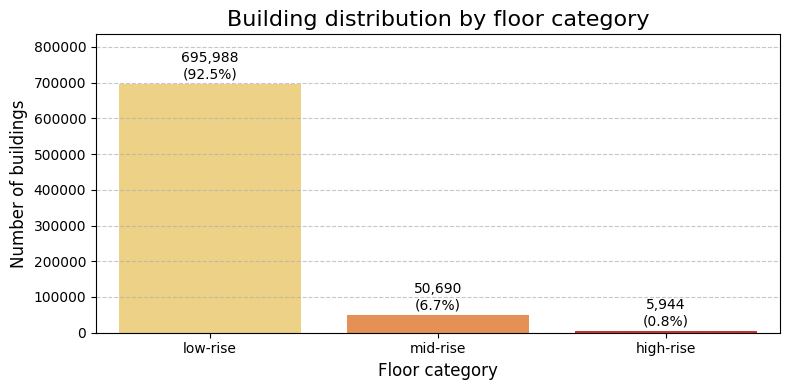

In [74]:
plt.figure(figsize=(8, 4), dpi=100)
ax = sns.barplot(x=floor_counts.index, y=floor_counts.values, palette='YlOrRd')
plt.title('Building distribution by floor category', fontsize=16)
plt.xlabel('Floor category', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(floor_counts) * 1.2)
total = len(bbl_df)
for i, count in enumerate(floor_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(floor_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### check nan, just to make sure our function works well

In [75]:
bbl_df['floor_category'].isna().sum()

np.int64(0)

# **Added Feature 5**: Categorize buildings based on the **rent regulation acts** eras they were built in.

Categorize bulidings based on the **rent regulation acts** in different eras.

https://hypocritereader.com/81/rent-regulation-nyc#:~:text=In%201962%2C%20the%20state%20granted,rent%20regulation%20than%20rent%20control.
- "In 1947, the Emergency Price Control Act expired and congress passed the Federal Housing and Rent Act, which kept controls in place but exempted properties constructed after 1947."
- In 1970, "...the legislature passed and Governor Rockefeller signed “vacancy decontrol,” which mandated that any stabilized or controlled unit that became vacant would automatically be deregulated."
- "In 1994 the New York City Council, at the behest of Speaker Peter Vallone, passed a bill extending decontrol to any apartment that became vacant with a rent over $2000 a month beyond the three month
window the legislature had created the year before."

In [76]:
def categorize_rent_era(year):
    if year < 1947:
        return 'Pre-1947, pre-rent-control'
    elif 1947 <= year <= 1969:
        return '1947–1969, rent-control'
    elif 1970 <= year <= 1993:
        return '1970–1993, deregularization'
    else:
        return '1994–Present, vacancy decontrol'
bbl_df['rent_era'] = bbl_df['yearbuilt'].apply(categorize_rent_era)

In [77]:
era_counts = bbl_df['rent_era'].value_counts()
era_order = [
    'Pre-1947, pre-rent-control',
    '1947–1969, rent-control',
    '1970–1993, deregularization',
    '1994–Present, vacancy decontrol'
]
era_counts = era_counts.reindex(era_order)

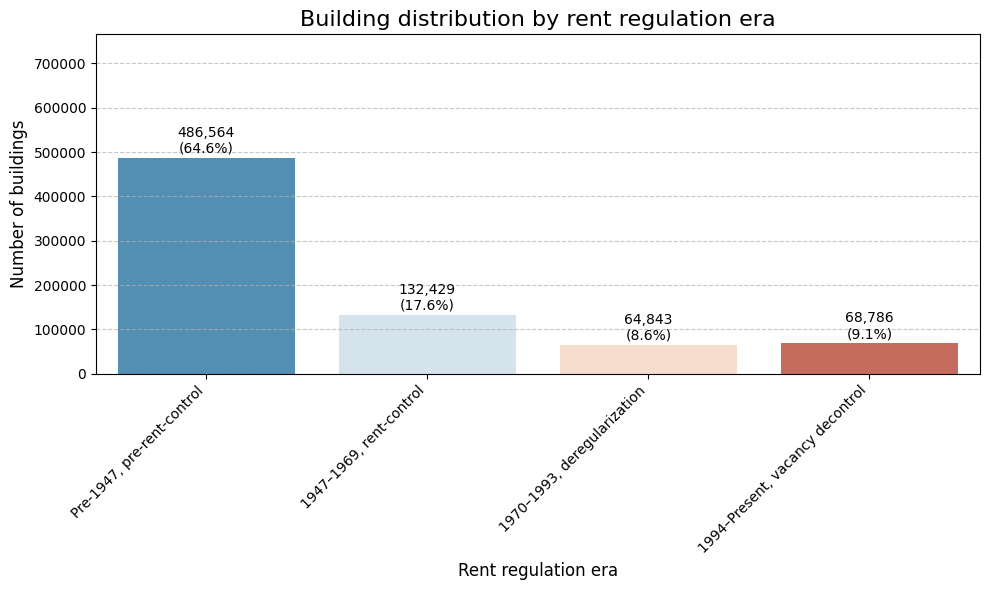

In [78]:
plt.figure(figsize=(10, 6), dpi=100)
ax = sns.barplot(x=era_counts.index, y=era_counts.values, palette='RdBu_r')
plt.title('Building distribution by rent regulation era', fontsize=16)
plt.xlabel('Rent regulation era', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(floor_counts) * 1.1)
total = len(bbl_df)
for i, count in enumerate(era_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(era_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [79]:
bbl_df['rent_era'].unique()

array(['1994–Present, vacancy decontrol', 'Pre-1947, pre-rent-control',
       '1947–1969, rent-control', '1970–1993, deregularization'],
      dtype=object)

### Check nans.

In [80]:
bbl_df['rent_era'].isna().sum()

np.int64(0)

# **Added Feature 6**: Categorize buildings based on the **Architectural Styles** eras they were built in.

Categorize the buildings' eras based on the dominating **architectural styles** in that period:
source: http://architecture-history.org/schools/NEW%20YORK,%20USA.html#:~:text=The%20modern%20architecture%20of%20New,architects%20and%20their%20large%20firms.

- Beaux-Arts Architecture in New York, 1900-20s
- Art Deco Skyscrapers, 1920s-30s
- Manhattan Modern, 1930s-40s
- The International Style, 1950s-70s
- Alternative Modernism in New York, 1960s-80s
- Post-Modernism, 1980s - 2000
- New Architecture in New York, 2001 into the Future

In [81]:
def categorize_architectural_style(year):
    if year < 1900:
        return 'Pre-1900'
    elif 1900 <= year <= 1920:
        return '1900–1920, Beaux-Arts'
    elif 1921 <= year <= 1930:
        return '1921–1930, Art Deco Skyscrapers'
    elif 1931 <= year <= 1950:
        return '1931–1950, Manhattan Modern'
    elif 1951 <= year <= 1980:
        return '1951–1980, the International Style, Alternative Modernism'
    elif 1981 <= year <=2000:
        return '1981–2000, Post-Modernism'
    else:
        return '2001-present, New Architecture'

bbl_df['architectural_style'] = bbl_df['yearbuilt'].apply(categorize_architectural_style)

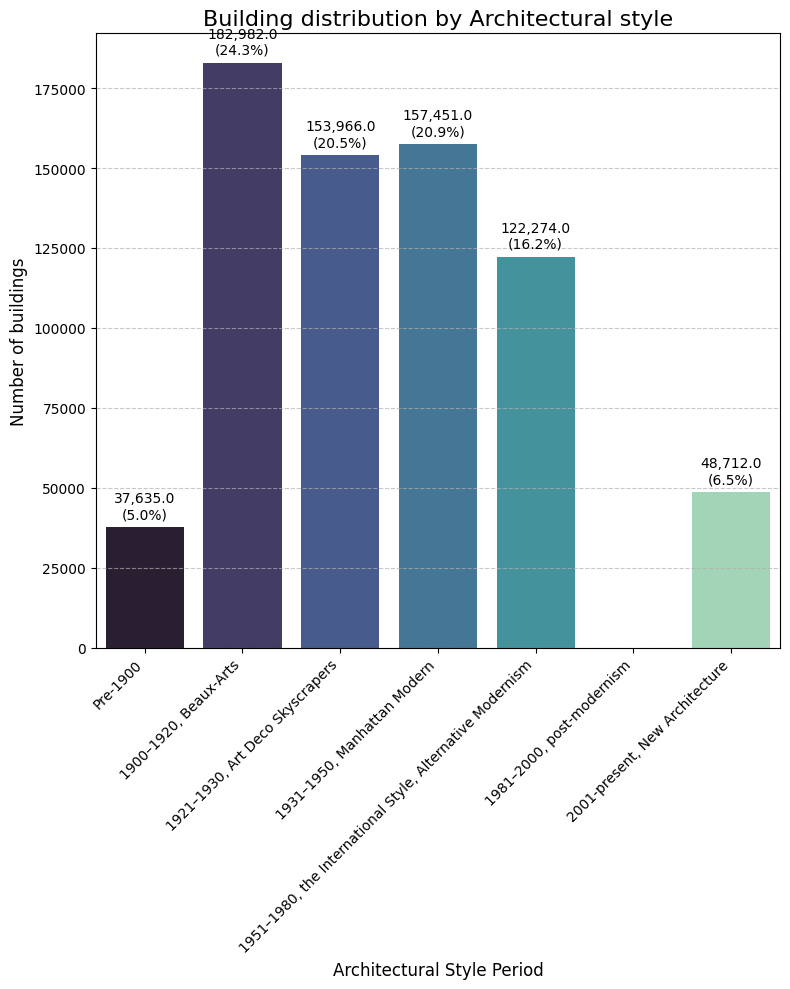

In [82]:
style_counts = bbl_df['architectural_style'].value_counts()
style_order = [
    'Pre-1900',
    '1900–1920, Beaux-Arts',
    '1921–1930, Art Deco Skyscrapers',
    '1931–1950, Manhattan Modern',
    '1951–1980, the International Style, Alternative Modernism',
    '1981–2000, post-modernism',
    '2001-present, New Architecture'
]
style_counts = style_counts.reindex(style_order)
plt.figure(figsize=(8, 10))
ax = sns.barplot(x=style_counts.index, y=style_counts.values, palette='mako')
plt.title('Building distribution by Architectural style', fontsize=16)
plt.xlabel('Architectural Style Period', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0, max(floor_counts)*1)
total = len(bbl_df)
for i, count in enumerate(style_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(style_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [83]:
bbl_df['architectural_style'].isna().sum()

np.int64(0)

# **Added Feature 7**: Categorize buildings based on the **Economic Development** eras they were built in.

Categorize buildings based on NYC's **economic development** phases:

- Pre-1929: Pre-great depression.
- 1930–1945: great depression and WWII.
- 1946–1975: post-war economic boom.
- 1976–1990: fiscal crisis and recovery.
- 1991–2008: modern economic growth.
- 2009–2019: post-financial crisis and pre covid.
- 2020 - present: covid and post covid


In [84]:
def categorize_economic_period(year):
    if year < 1929:
        return 'Pre-1929, pre-great depression'
    elif 1929 <= year <= 1945:
        return '1930-1945, great depression and WWII'
    elif 1946 <= year <= 1975:
        return '1946–1975, pst war economic boom'
    elif 1976 <= year <= 1990:
        return '1976–1990, fiscal crisis and recovery'
    elif 1991 <= year <= 2008:
        return '1991–2008, modern economic growth'
    else:
        return '2009–present, post-financial crisis'

bbl_df['economic_period'] = bbl_df['yearbuilt'].apply(categorize_economic_period)

In [85]:
period_counts = bbl_df['economic_period'].value_counts()
period_order = [
    'Pre-1929, pre-great depression',
    '1930-1945, great depression and WWII',
    '1946–1975, pst war economic boom',
    '1976–1990, fiscal crisis and recovery',
    '1991–2008, modern economic growth',
    '2009–present, post-financial crisis',
]
period_counts = period_counts.reindex(period_order)

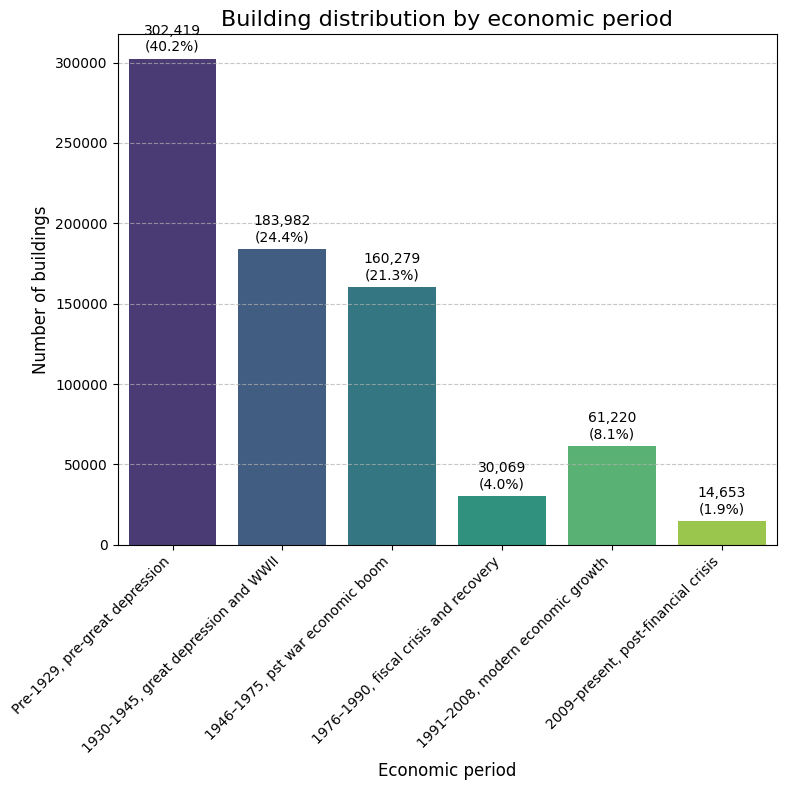

In [86]:
plt.figure(figsize=(8, 8), dpi=100)
ax = sns.barplot(x=period_counts.index, y=period_counts.values, palette='viridis')
plt.title('Building distribution by economic period', fontsize=16)
plt.xlabel('Economic period', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0, max(floor_counts) * 0.8)
total = len(bbl_df)
for i, count in enumerate(period_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(period_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [88]:
bbl_df['economic_period'].isna().sum()

np.int64(0)

# **Added Feature 8**: Categorize buildings based on the **The Number of Units** they have.

In [147]:
bbl_df.unitsres.describe()

,unitsres
count,752622.000000
mean,4.361835
std,32.748434
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,10914.000000


In [89]:
def categorize_residential_units(units):
    if units <= 1:
        return 'single-unit'
    elif units == 2:
        return '2-unit'
    elif 3 <= units <= 5:
        return '3-5 units'
    elif 6 <= units <= 20:
        return '6-20 units'
    elif 21 <= units <= 100:
        return '21-100 units'
    elif units > 100:
        return '100+ units'
bbl_df['residential_units_category'] = bbl_df['unitsres'].apply(categorize_residential_units)

In [90]:
unit_counts = bbl_df['residential_units_category'].value_counts()
unit_order = [
    'single-unit',
    '2-unit',
    '3-5 units',
    '6-20 units',
    '21-100 units',
    '100+ units',
]
unit_counts = unit_counts.reindex([cat for cat in unit_order if cat in unit_counts.index])

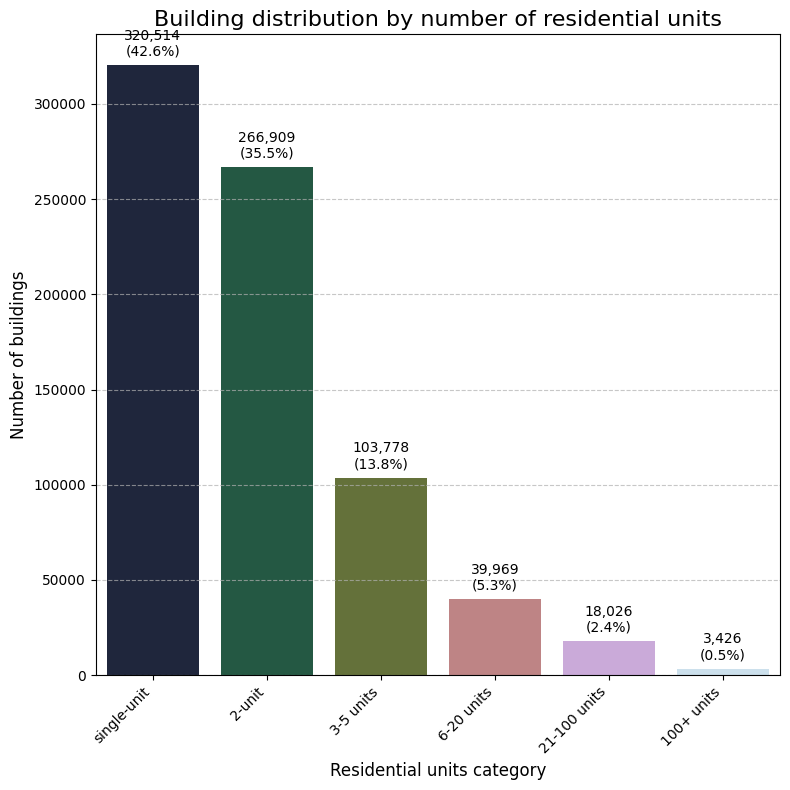

In [91]:
plt.figure(figsize=(8, 8), dpi=100)
ax = sns.barplot(x=unit_counts.index, y=unit_counts.values, palette='cubehelix')
plt.title('Building distribution by number of residential units', fontsize=16)
plt.xlabel('Residential units category', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
total = len(bbl_df)
for i, count in enumerate(unit_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(unit_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [92]:
bbl_df.ownertype.unique()

array([nan, 'X', 'O', 'C', 'P', 'M'], dtype=object)

In [93]:
bbl_df['residential_units_category'].isna().sum()

np.int64(0)

# **Added Feature 9**: Categorize buildings based on the **If they are LLC owned**

**Why we do not use bbl to find ownertype? Too many nans**

In [96]:
nan_count = bbl_df.ownertype.isna().sum()
nan_percentage = (bbl_df.ownertype.isna().mean()) * 100
print(f"percentage of NaN : {nan_percentage:.2f}%"), print(nan_count)

percentage of NaN : 99.06%
745554


(None, None)

In [99]:
nan_count = bbl_df.ownertype.isna().sum()
nan_percentage = (bbl_df.ownertype.isna().mean()) * 100
print(f"percentage of NaN : {nan_percentage:.2f}%"), print(nan_count)

percentage of NaN : 99.06%
745554


(None, None)

In [100]:
nan_count = bbl_df.ownername.isna().sum()
nan_percentage = (bbl_df.ownername.isna().mean()) * 100
print(f"percentage of NaN : {nan_percentage:.2f}%"), print(nan_count)
# good

percentage of NaN : 0.00%
0


(None, None)

In [101]:
bbl_df.ownername.unique()

array(['EAST 69 AVENUE N DEVELOPMENT, LLC', '85 CALYER STREET LLC',
       'SERLIN BUILDING LIMITED PARTNERSHIP', ..., 'CHEDISTER, JOHN R',
       'LY, JANSON', 'SPRINGER, LINSWELL E'], dtype=object)

In [102]:
len(bbl_df.ownername.unique())

677583

In [103]:
llc_owners = bbl_df[bbl_df['ownername'].str.contains('LLC', case=False, na=False)]
llc_count = llc_owners.shape[0]
llc_count, 65167/677583

(65167, 0.09617567146755453)

In [104]:
# add a new column 'is_llc' that is true if the owner is an LLC, false otherwise
# to later see the correlation between is_llc and eviction rate
bbl_df['is_llc'] = bbl_df['ownername'].str.contains('LLC', case=False, na=False)

In [105]:
llc_percentage = (llc_count / bbl_df.shape[0]) * 100
print(f"percentage of LLC-owned buildings: {llc_percentage:.2f}%")

percentage of LLC-owned buildings: 8.66%


In [106]:
llc_owners[['bbl', 'ownername']].head(10)

,bbl,ownername
17,3083660222,"EAST 69 AVENUE N DEVELOPMENT, LLC"
58,3025710028,85 CALYER STREET LLC
110,4000520007,"TRIBECA TREASURES, LLC"
141,3079650040,"525 EAST 86TH STREET GROUP, LLC"
166,4007030040,DANAKO LLC
199,3033860005,441 IRVING AVENUE LLC
249,1000110010,BEAVER STREET COMMONS LLC
262,3034710042,81 VANDERVEER STREET LLC
283,2057600161,5721 BROADWAY DEVELOPMENT LLC
292,1014430122,"68TH STREET ASSOCIATES #1, LLC"


In [107]:
bbl_df['is_llc'].isna().sum()

np.int64(0)

# **Added Feature 10**: Categorize buildings based on the **Building Area/size**

- First, we categorize based on the practical interpretations of what is tiny, what is small, and what is large for a building.

- Then, we categorize based on the quartiles.

**Building Area** \
bldgarea: refers to the total building floor area for a given tax lot, measured in square feet
https://www.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto-readme.pdf?r=20v6#:~:text=Changes%20to%20the%20Property%20Tax%20System%20(PTS),~6%%20decrease%20in%20aggregate%20BUILDING%20AREA%20(bldgarea).

In [108]:
bbl_df.bldgarea.head()

,bldgarea
17,1288.0
58,3478.0
79,4125.0
110,7416.0
126,2112.0


count    7.526220e+05
mean     4.603563e+03
std      3.267927e+04
min      0.000000e+00
25%      1.440000e+03
50%      2.000000e+03
75%      2.862000e+03
max      1.354011e+07
Name: bldgarea, dtype: float64


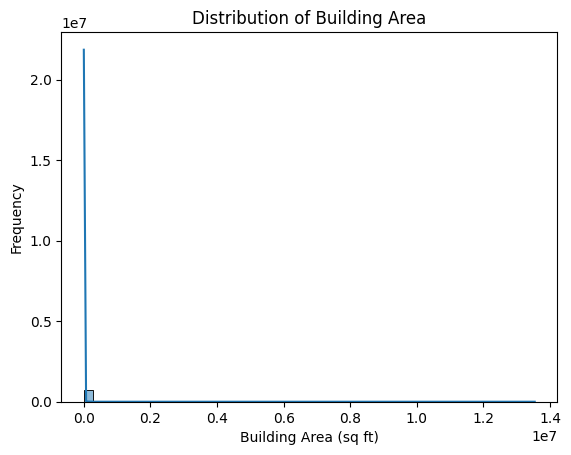

In [109]:
print(bbl_df['bldgarea'].describe())
sns.histplot(bbl_df['bldgarea'], bins=50, kde=True)
plt.title('Distribution of Building Area')
plt.xlabel('Building Area (sq ft)')
plt.ylabel('Frequency')
plt.show()
# extremely right skewed.

Since 25th percentile is 1,440 sq ft, so I set 1,000 sq ft as the first threshold to capture very small buildings. The median (50th percentile) is 2,000 sq ft, which became another natural break point
The 75th percentile is 2,864 sq ft, so I rounded to 3,000 sq ft for the next category

**Real-world building situation:**

Below 1,000 sq ft typically represents very small residential units or small retail spaces 1,000-2,000 sq ft usually includes single-family homes and small townhouses 2,000-3,000 sq ft generally captures larger townhouses and small apartment buildings 3,000-5,000 sq ft represents small multi-unit buildings 5,000-10,000 sq ft includes medium apartment or office buildings. Above 10,000 sq ft we start moving into larger commercial and multi-unit properties

In [110]:
def categorize_building_area(area):
    if area == 0:
        return "nan/zero"
    elif area <= 1000:
        return "tiny"
    elif area <= 2000:
        return "very small"
    elif area <= 3000:
        return "small"
    elif area <= 5000:
        return "medium-small"
    elif area <= 10000:
        return "medium"
    elif area <= 25000:
        return "large"
    elif area <= 100000:
        return "very large"
    else:
        return "mega"

bbl_df['building_size_category'] = bbl_df['bldgarea'].apply(categorize_building_area)

In [111]:
bbl_df['building_size_category'] = bbl_df['building_size_category'].astype(str)
bbl_df['building_size_category'] = bbl_df['bldgarea'].apply(categorize_building_area)

In [112]:
size_categories = [
  "tiny", "very small", "small", "medium-small",
    "medium", "large", "very large", "mega"
]
bbl_df['building_size_category'] = bbl_df['bldgarea'].apply(categorize_building_area)
bbl_df['building_size_category'] = pd.Categorical(
    bbl_df['building_size_category'],
    categories=size_categories,
    ordered=True
)

In [113]:
building_sizes = bbl_df[bbl_df['bldgarea'] > 0]['bldgarea']
q1 = building_sizes.quantile(0.25)
q2 = building_sizes.quantile(0.50)
q3 = building_sizes.quantile(0.75)
print(f"quartile thresholds (sq ft):")
print(f"25th percentile: {q1:.1f}")
print(f"median: {q2:.1f}")
print(f"75th percentile: {q3:.1f}")

quartile thresholds (sq ft):
25th percentile: 1440.0
median: 2000.0
75th percentile: 2862.0


In [114]:
has_zeros = (bbl_df['bldgarea'] == 0).any()
(bbl_df['bldgarea'] == 0).sum(), bbl_df.shape

(np.int64(3), (752622, 109))

In [115]:
bbl_df = bbl_df[bbl_df['bldgarea'] != 0]
bbl_df.shape

(752619, 109)

In [116]:
bbl_df['building_size_category'].isna().sum()

np.int64(0)

In [117]:
category_counts = bbl_df['building_size_category'].value_counts().sort_index()

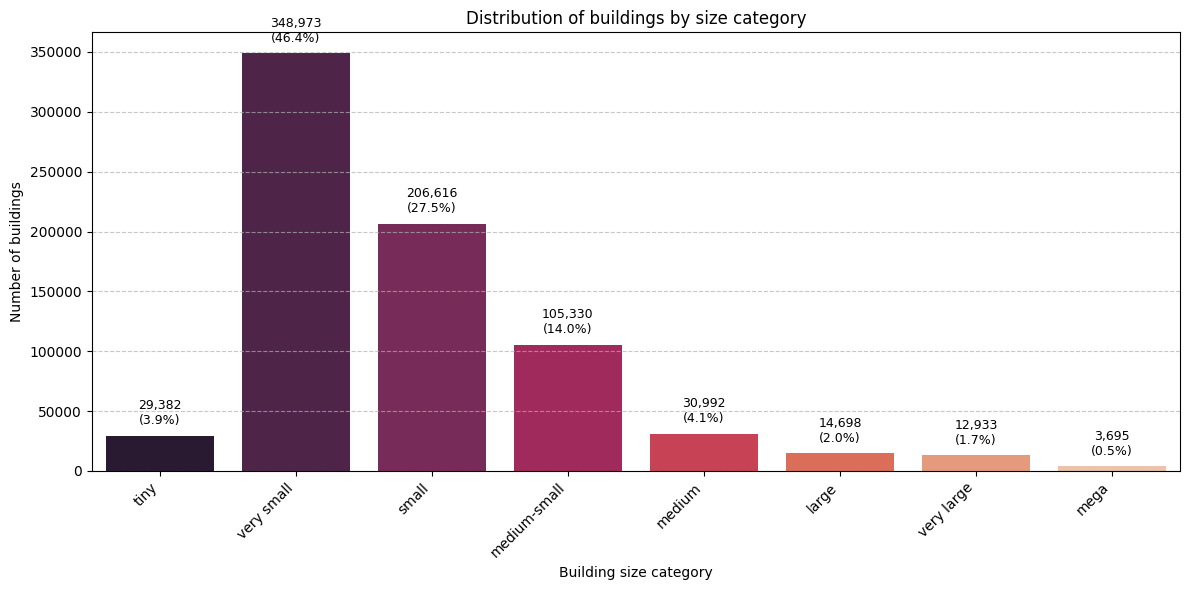

In [118]:
plt.figure(figsize=(12, 6), dpi=100)

# some good colors: 'viridis', 'mako', 'rocket', 'cubehelix', 'Blues', 'YlOrRd'
ax = sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette='rocket'
)

plt.title('Distribution of buildings by size category')
plt.xlabel('Building size category')
plt.ylabel('Number of buildings')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

total = len(bbl_df)
for i, count in enumerate(category_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(category_counts) * 0.02),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### categorize based on the quartile the buildings' areas are in.

In [119]:
quartile_labels = ['Q1 (smallest 25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (largest 25%)']

In [120]:
# simplified the previous version
bbl_df['size_quartile'] = pd.cut(
    bbl_df['bldgarea'],
    bins=[0, q1, q2, q3, float('inf')],
    labels=quartile_labels,
    include_lowest=True
)

In [121]:
quartile_analysis = bbl_df.groupby('size_quartile').agg({
    'bldgarea': ['min', 'max', 'mean', 'count']
})
quartile_analysis

bldgarea                                  
                       min         max          mean   count
size_quartile                                               
Q1 (smallest 25%)      1.0      1440.0   1189.178608  191918
Q2 (25-50%)         1441.0      2000.0   1718.260066  186437
Q3 (50-75%)         2001.0      2862.0   2370.774547  186194
Q4 (largest 25%)    2863.0  13540113.0  13158.648205  188070

In [122]:
summary = pd.DataFrame({
    'Size Quartile': quartile_analysis.index,
    'Building Count': quartile_analysis[('bldgarea', 'count')],
    'Count Percentage': (quartile_analysis[('bldgarea', 'count')] / len(bbl_df) * 100).round(2),
    'Min Area (sq ft)': quartile_analysis[('bldgarea', 'min')].round(1),
    'Max Area (sq ft)': quartile_analysis[('bldgarea', 'max')].round(1),
    'Mean Area (sq ft)': quartile_analysis[('bldgarea', 'mean')].round(1)
})
summary

,Size Quartile,Building Count,Count Percentage,Min Area (sq ft),Max Area (sq ft),Mean Area (sq ft)
size_quartile,,,,,,
Q1 (smallest 25%),Q1 (smallest 25%),191918,25.50,1.0,1440.0,1189.2
Q2 (25-50%),Q2 (25-50%),186437,24.77,1441.0,2000.0,1718.3
Q3 (50-75%),Q3 (50-75%),186194,24.74,2001.0,2862.0,2370.8
Q4 (largest 25%),Q4 (largest 25%),188070,24.99,2863.0,13540113.0,13158.6


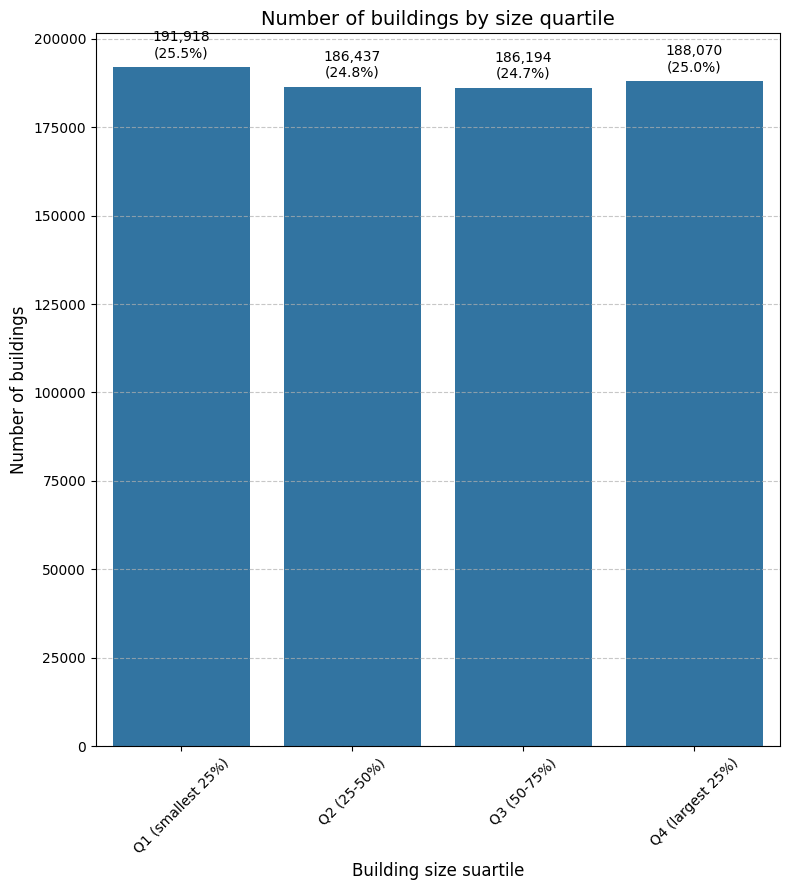

In [123]:
plt.figure(figsize=(8, 9), dpi=100)
counts = bbl_df['size_quartile'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values)
plt.title('Number of buildings by size quartile', fontsize=14)
plt.xlabel('Building size suartile', fontsize=12)
plt.ylabel('Number of buildings', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# corrected, added %
total = len(bbl_df)
for i, count in enumerate(counts):
    percentage = count / total * 100
    plt.text(i, count + (max(counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
# supposed to be roughly evenly distributed

In [124]:
bbl_df['size_quartile'].isna().sum()

np.int64(0)

# **Added Feature 11**: Categorize buildings based on the **building age** eras they were built in.

In [125]:
min(bbl_df['yearbuilt']), max(bbl_df['yearbuilt'])

(1720.0, 2020.0)

In [126]:
def categorize_building_age(year):
    if year < 1900:
        return "Pre-1900"
    elif 1900 <= year <= 1909:
        return "1900-1909"
    elif 1910 <= year <= 1919:
        return "1910-1919"
    elif 1920 <= year <= 1929:
        return "1920-1929"
    elif 1930 <= year <= 1939:
        return "1930-1939"
    elif 1940 <= year <= 1949:
        return "1940-1949"
    elif 1950 <= year <= 1959:
        return "1950-1959"
    elif 1960 <= year <= 1969:
        return "1960-1969"
    elif 1970 <= year <= 1979:
        return "1970-1979"
    elif 1980 <= year <= 1989:
        return "1980-1989"
    elif 1990 <= year <= 1999:
        return "1990-1999"
    elif 2000 <= year <= 2009:
        return "2000-2009"
    elif 2010 <= year <= 2020:
        return "2010-2020"
bbl_df['decade'] = bbl_df['yearbuilt'].apply(categorize_building_age)

In [127]:
decade_counts = bbl_df['decade'].value_counts()
decade_order = [
    "Pre-1900", "1900-1909", "1910-1919", "1920-1929", "1930-1939", "1940-1949",
    "1950-1959", "1960-1969", "1970-1979", "1980-1989", "1990-1999", "2000-2009", "2010-2020"
]
decade_counts = decade_counts.reindex(decade_order)

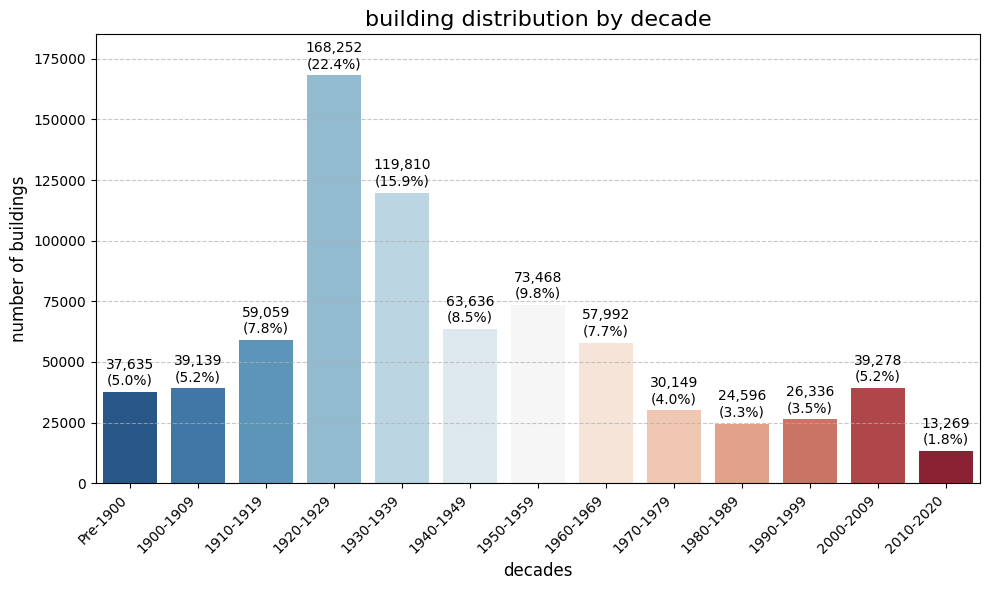

In [128]:
plt.figure(figsize=(10, 6), dpi=100)  # Increased height from 3 to 8
ax = sns.barplot(x=decade_counts.index, y=decade_counts.values, palette='RdBu_r')
plt.title('building distribution by decade', fontsize=16)
plt.xlabel('decades', fontsize=12)
plt.ylabel('number of buildings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(decade_counts) * 1.1)  # Changed from floor_counts to decade_counts

total = len(bbl_df)
for i, count in enumerate(decade_counts):
    percentage = count / total * 100
    plt.text(i, count + (max(decade_counts) * 0.01),
             f"{count:,}\n({percentage:.1f}%)",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [129]:
bbl_df.decade.isna().sum()

np.int64(0)

# **Final check nans**

In [130]:
nan_df = pd.DataFrame({
    'column_name': bbl_df.columns,
    'nan_count': bbl_df.isna().sum(),
    'nan_percentage': (bbl_df.isna().sum() / len(bbl_df) * 100).round(2)
})
nan_df = nan_df.sort_values('nan_count', ascending=False)
nan_df

,column_name,nan_count,nan_percentage
zonedist4,zonedist4,752619,100.00
spdist3,spdist3,752619,100.00
masdate,masdate,752619,100.00
landmkdate,landmkdate,752619,100.00
edesignum,edesignum,752619,100.00
basempdate,basempdate,752619,100.00
polidate,polidate,752619,100.00
geom,geom,752619,100.00
notes,notes,752619,100.00
edesigdate,edesigdate,752619,100.00


In [134]:
high_nan_columns = nan_df[nan_df['nan_percentage'] == 100]['column_name'].tolist()
high_nan_columns, bbl_df.shape
# luckily, none of these are important

(['zonedist4',
  'spdist3',
  'masdate',
  'landmkdate',
  'edesignum',
  'basempdate',
  'polidate',
  'geom',
  'notes',
  'edesigdate',
  'rpaddate',
  'dcasdate',
  'zoningdate',
  'spdist2'],
 (752619, 111))

In [135]:
bbl_df_cleaned = bbl_df.drop(columns=high_nan_columns)
bbl_df_cleaned.shape # 14 columns less

(752619, 97)

We do not need to worry about every column that has some nan values, because we will eventually only select a few of the columns for further analysis and merge in the next notebook. Dropping them now only reduce potentially helpful information.

In [144]:
bbl_df_cleaned.to_csv('/content/drive/My Drive/X999/bbl_cleaned.csv', index=False)

In [193]:
# list(bbl_df.columns)

In [142]:
newly_created_columns = [
    'bbl',
    'building_type',
    'building_category',
    'is_condo',
    'floor_category',
    'rent_era',
    'architectural_style',
    'economic_period',
    'residential_units_category',
    'is_llc',
    'building_size_category',
    'size_quartile',
    'decade'
]
# 12 columns except bbl
selected_df = bbl_df[newly_created_columns]

In [143]:
selected_df.head()

,bbl,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade
17,3083660222,post-war,single-family,False,low-rise,"1994–Present, vacancy decontrol","2001-present, New Architecture","2009–present, post-financial crisis",single-unit,True,very small,Q1 (smallest 25%),2010-2020
58,3025710028,post-war,single-family,False,low-rise,"1994–Present, vacancy decontrol","2001-present, New Architecture","2009–present, post-financial crisis",single-unit,True,medium-small,Q4 (largest 25%),2010-2020
79,3031970008,pre-war,primarily_res_with_mixed_use,False,low-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",3-5 units,False,medium-small,Q4 (largest 25%),1930-1939
110,4000520007,post-war,walk-up,False,mid-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",6-20 units,True,medium,Q4 (largest 25%),1950-1959
126,3067140055,pre-war,walk-up,False,low-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",3-5 units,False,small,Q3 (50-75%),1930-1939


In [145]:
bbl_df_cleaned.head()

,borough,block,lot,community board,census tract 2010,cb2010,schooldist,council district,postcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,zonedist2,zonedist3,overlay1,overlay2,spdist1,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,zmcode,sanborn,taxmap,appbbl,appdate,plutomapid,version,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,dcpedited,building_category,building_type,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade
17,BK,8366,222,318.0,696.02,2002.0,22.0,46.0,11234.0,E323,63.0,8822.0,3.0,4E,6815 AVENUE N,R3-1,NaN,NaN,NaN,NaN,NaN,NaN,False,A5,1.0,0.0,NaN,"EAST 69 AVENUE N DEVELOPMENT, LLC",2241.0,1288.0,0.0,1288.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,1,1.0,27.0,83.0,19.0,33.0,NaN,2.0,False,0.0,2.0,5918.0,5918.0,0.0,2019.0,0.0,0.0,NaN,NaN,0.57,0.50,0.0,1.0,3,3083660222,NaN,69602.0,1008419.0,165883.0,40.621954,-73.912938,23b,NaN,315 067,3.0,3.083660e+09,04/26/2019,1,20v5,18.0,35.0,NaN,NaN,NaN,single-family,post-war,False,low-rise,"1994–Present, vacancy decontrol","2001-present, New Architecture","2009–present, post-financial crisis",single-unit,True,very small,Q1 (smallest 25%),2010-2020
58,BK,2571,28,301.0,561.00,1005.0,14.0,33.0,11222.0,L106,94.0,100.0,3.0,1A,87 CALYER STREET,M1-2/R6B,NaN,NaN,NaN,NaN,MX-8,NaN,False,A5,1.0,0.0,NaN,85 CALYER STREET LLC,1862.0,3478.0,0.0,3478.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3,1,1.0,18.0,100.0,18.0,60.0,N,3.0,False,5.0,2.0,51000.0,66780.0,0.0,2018.0,0.0,2017.0,NaN,NaN,1.87,2.00,2.0,2.0,3,3025710028,NaN,561.0,995995.0,204223.0,40.727214,-73.957625,12c,NaN,304 033,30902.0,3.025710e+09,05/09/2019,1,20v5,1.0,30.0,NaN,NaN,NaN,single-family,post-war,False,low-rise,"1994–Present, vacancy decontrol","2001-present, New Architecture","2009–present, post-financial crisis",single-unit,True,medium-small,Q4 (largest 25%),2010-2020
79,BK,3197,8,304.0,429.00,1002.0,32.0,34.0,11237.0,E218,83.0,3200.0,3.0,1B,109 WILSON AVENUE,R6,NaN,NaN,NaN,NaN,NaN,NaN,False,S4,4.0,0.0,NaN,SERLIN BUILDING LIMITED PARTNERSHIP,2500.0,4125.0,1375.0,2750.0,0.0,1375.0,0.0,0.0,0.0,0.0,2.0,1.0,3,4,5.0,25.0,100.0,25.0,55.0,N,0.0,False,3.0,5.0,158850.0,381150.0,45280.0,1931.0,2001.0,0.0,NaN,NaN,1.65,2.43,0.0,4.8,3,3031970008,NaN,429.0,1004619.0,194842.0,40.701450,-73.926539,13b,NaN,309 037,31102.0,NaN,NaN,1,20v5,4.0,34.0,NaN,NaN,NaN,primarily_res_with_mixed_use,pre-war,False,low-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",3-5 units,False,medium-small,Q4 (largest 25%),1930-1939
110,QN,52,7,402.0,7.00,1000.0,30.0,26.0,11101.0,L115,108.0,720.0,4.0,2A,11-43 45 AVENUE,M1-4/R6A,NaN,NaN,NaN,NaN,LIC,NaN,False,C1,2.0,0.0,NaN,"TRIBECA TREASURES, LLC",2500.0,7416.0,380.0,7036.0,0.0,0.0,0.0,0.0,0.0,380.0,2.0,1.0,5,7,7.0,25.0,100.0,25.0,100.0,N,0.0,False,5.0,0.0,10350.0,977850.0,923360.0,1958.0,2007.0,2007.0,NaN,NaN,2.97,3.00,2.0,3.0,4,4000520007,NaN,7.0,998601.0,211689.0,40.747702,-73.948207,9b,NaN,401 019,40101.0,NaN,NaN,1,20v5,2.0,41.0,NaN,NaN,NaN,walk-up,post-war,False,mid-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",6-20 units,True,medium,Q4 (largest 25%),1950-1959
126,BK,6714,55,314.0,534.00,3000.0,21.0,44.0,11230.0,L156,70.0,7310.0,3.0,4D,1081 EAST 12 STREET,R5,R7A,NaN,NaN,NaN,NaN,NaN,True,C3,2.0,0.0,NaN,"RAMBOD, SHAHROKH",3500.0,2112.0,0.0,2112.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2,4,4.0,35.0,100.0,22.0,48.0,N,0.0,False,5.0,5.0,55350.0,255600.0,2390.0,